# COE Analysis

### Purpose

This is an explanatory analysis intended to enlighten new car buyers on how the COE bidding system in Singapore works, and what they ought to look out for when purchasing a new car.

### Audience

New car buyers who are not particularly affluent and are not familiar with the COE bidding system

### Objectives:

1.  Find factors of COE pricing trends (premium & pqp)
2.  Find relationships/correlations among the factors

## A Brief Introduction to Singapore's COE Bidding System

In order to drive a vehicle on Singapore roads, one must obtain and possess a valid Certificate of Entitlement (COE) in addition to a valid driving licence. COE was implemented with the intent to reduce the number of cars on Singapore roads.

COEs are obtained through a process known as a bidding system. Car owners submit their bids, which is the amount they are willing to pay for their COE. There will be a quota, which is the number of COEs released during each bidding session (twice per month).

The quota is calculated based on 3 factors:

1.  Number of vehicles deregistered (expired or scrapped)
2.  Number of temporary COEs that were expired or cancelled
3.  Allowable vehicle population growth

<br />

Since 2012, [taxis are exempt from COE requirement](https://www.sgcarmart.com/news/article.php?AID=6475#:~:text=Taxis%20will%20be%20removed%20from,Authority%20(LTA)%20announced%20today.&text=Under%20the%20new%20move%2C%20taxi,under%20the%20Vehicle%20Quota%20System.)

[What about private hire cars and parallel imported](https://www.straitstimes.com/singapore/transport/private-hire-demand-pushes-up-car-coe-premiums)


For more detailed explanations, _[click here](https://ucars.sg/blog/complete-guide-coe-bidding/)_

## Import Dependencies

In [215]:
# data manipulation dependencies
import numpy as np
import pandas as pd
import statsmodels.api as sm

# graphing dependencies
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go 
import plotly.express as px

## Preparation

### Set Seaborn Generic Theme

In [216]:
sns.set_theme(rc={'figure.figsize': (10, 6)}, palette='Set1')

### Load Dataset (from PDAS)

In [217]:
df = pd.read_csv('./data/final.csv', index_col=0)
df.head(n=10)
df = df.reset_index().assign(date=lambda x: x['month'].astype(str) + '/' + x['year'].astype(str))

## Dataset Adjustments

In [218]:
df_personal_cars = df[df['vehicle_class'].str.contains(r'Category (A|B)')]
df_exclude_2018 = df[df['year'] != 2018]

## Analysis

### Factor 1:   Vehicle Category

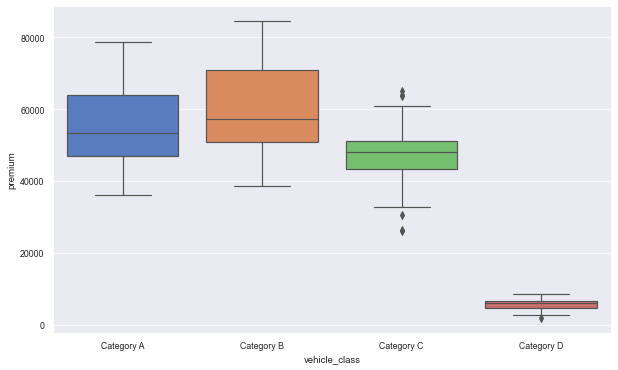

In [219]:
# COE by category
# COE is greatest for cars and cheapest for motorcycles (expected) (vehicle class)
with sns.axes_style(style='darkgrid'):
    with sns.plotting_context(context='paper'):
        with sns.color_palette(palette='muted'):
            ax = sns.boxplot(data=df, x='vehicle_class', y='premium')

Category is the most defining factor when it comes to COE pricing, <br />
with Categories A and B topping the charts.

Since Category C is reserved for industrial purposes

Proceeding onwards, Categories C and D will be excluded from the analyses.

To provide better context, these are the definitions of the above categories:

+   A)  Internal Combustion Engine (ICE) cars with an engine capacity of at most 1600cc and Electric cars with engine power of at most 97kW
+   B)  Internal Combustion Engine (ICE) cars with an engine capacity of at least 1600cc and Electric cars with engine power of at least 97kW
+   C)  Goods Vehicles (like trucks, lorries) and Buses
+   D)  Motorcycles

### Factor 2:   Quota of COE Bids

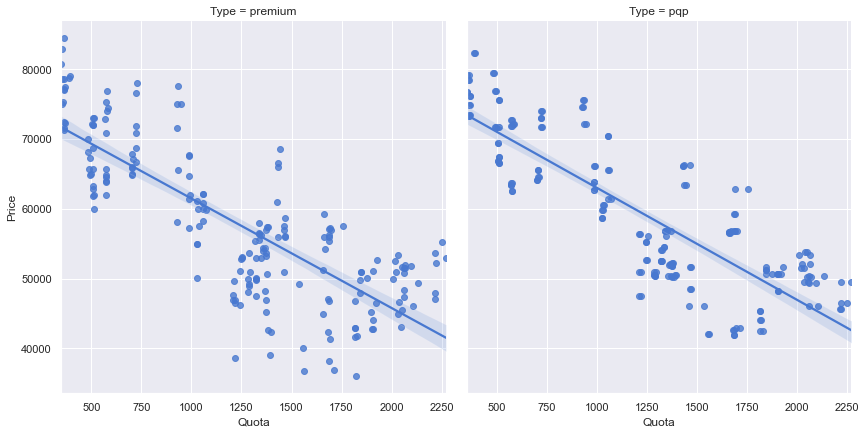

In [406]:
# COE by quota
# As expected, greater quota leads to lower price
with sns.color_palette('muted'):
    tmp = df_personal_cars.melt(id_vars='quota', value_vars=['premium', 'pqp'], var_name='Type', value_name='Price')
    g1 = sns.FacetGrid(tmp, col='Type', height=6, sharey=True)
    # ax = sns.regplot(data=tmp, x='quota', y='premium')
    g1.map_dataframe(sns.regplot, data=tmp, x='quota', y='Price')
    g1.set_xlabels('Quota')
    g1.set_ylabels('Price')

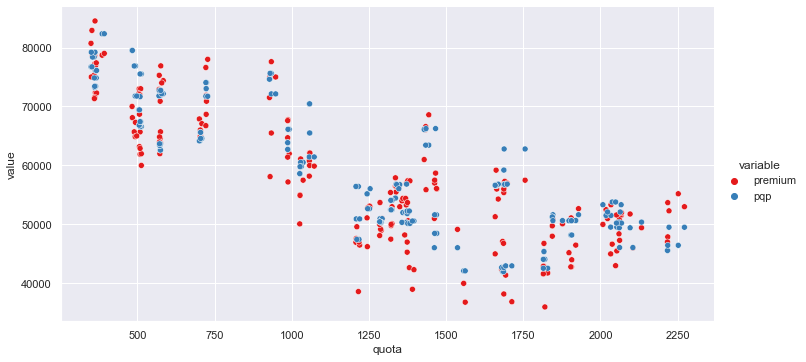

In [412]:
sns.relplot(data=df_personal_cars.melt(id_vars='quota', value_vars=['premium', 'pqp']), x='quota', y='value', hue='variable', kind='scatter', aspect=2)
sns.despine()

As quota increases, premiums and pqps drop

### Factor 3:   Bidding Session

<AxesSubplot:xlabel='premium', ylabel='Density'>

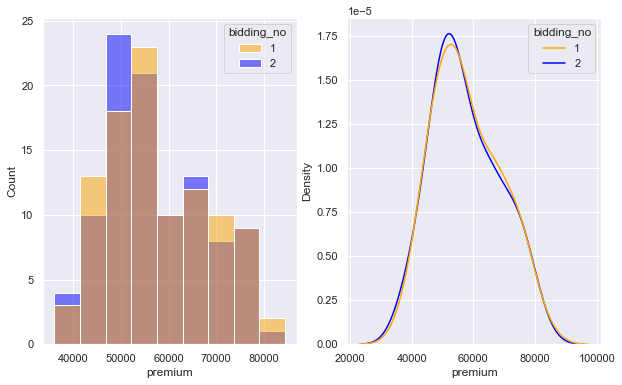

In [231]:
# g2 = sns.FacetGrid(data=df, row='bidding_no')
# g2.map_dataframe(sns.histplot, x='premium', hue='bidding_no' kde=True, fill=True, color='coral')
fig23, (ax4, ax5) = plt.subplots(nrows=1, ncols=2)
sns.histplot(data=df_personal_cars, x='premium', hue='bidding_no', fill=True, palette=['orange', 'blue'], ax=ax4)
sns.kdeplot(data=df_personal_cars, x='premium', hue='bidding_no', palette=['orange', 'blue'], ax=ax5)

[Text(0.0, 0, '2014'),
 Text(12.0, 0, '2015'),
 Text(24.0, 0, '2016'),
 Text(36.0, 0, '2017'),
 Text(48.0, 0, '2018')]

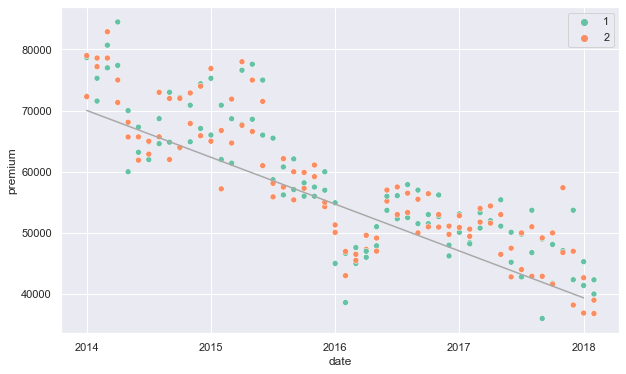

In [242]:
ax6 = sns.scatterplot(data=df_personal_cars, x='date', y='premium', hue='bidding_no', palette='Set2')
c, m = sm.OLS.from_formula(formula='premium ~ year', data=df_personal_cars).fit().params
sns.lineplot(x=[f'1/{i}' for i in range(2014, 2019)], y=np.arange(2014, 2019) * m + c, ax=ax6, color='darkgrey')
ax6.set_xticks([f'1/{i}' for i in range(2014, 2019)])
ax6.set_xticklabels([i for i in range(2014, 2019)])

<AxesSubplot:xlabel='premium difference', ylabel='date'>

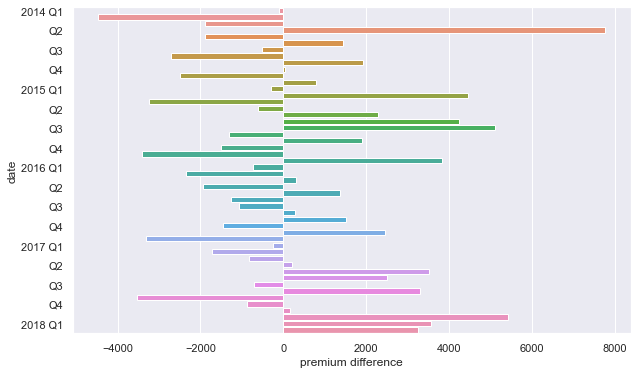

In [382]:
tmp4 = df_personal_cars.pivot_table(index='date', columns='bidding_no', values='premium')
difference = (tmp4[1] - tmp4[2]).to_frame('premium difference').reset_index()
difference['date'] = difference['date'].apply(lambda x: pd.to_datetime(x, format='%m/%Y'))
difference.sort_values('date', inplace=True)
ax10 = sns.barplot(data=difference, x='premium difference', y='date')
ax10.set_yticks(ax10.get_yticks()[ax10.get_yticks() % 3 == 0])
ax10.set_yticklabels([(f'{int(i / 12 + 2014)} ' if i % 12 == 0 else '') + f'Q{int((i % 12) / 3 + 1)}' for i in ax10.get_yticks()])
ax10

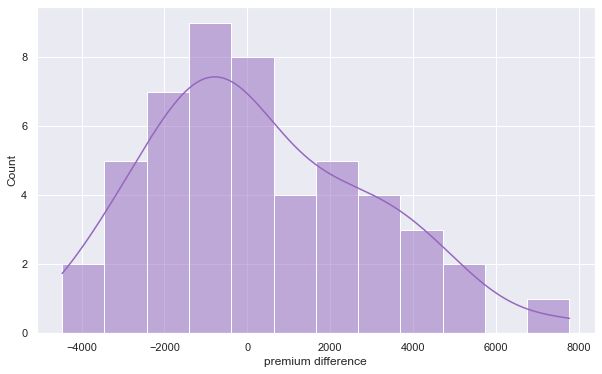

In [403]:
ax11 = sns.histplot(data=difference, x='premium difference', kde=True, bins=12, color='tab:purple')

There appears to be no significant difference in COE premium between bidding sessions from a broad overview. Variations appear to be random and

However, take a closer look and you'll find that there is significant variation between the 2 bidding sessions.

Bidding session 2 has more expensive premiums consistently, but there's a chance that bidding session 1 offers even larger disparities.

### Correlation 1:  Quota ~ Year of Issuance

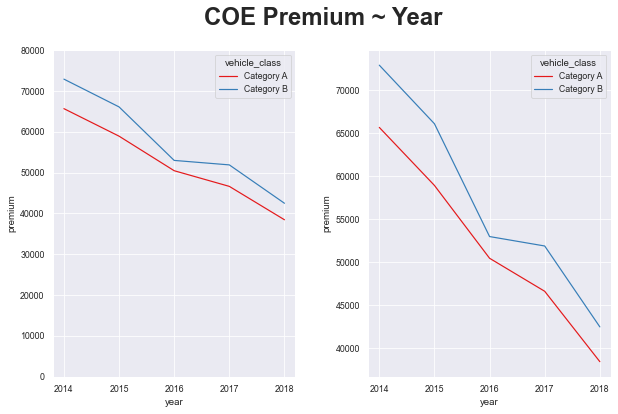

In [414]:
with sns.axes_style(style='darkgrid'):
    with sns.plotting_context(context='paper'):
        # fig2 = plt.Figure(figsize=(10, 4))
        fig2, (ax2, ax3) = plt.subplots(nrows=1, ncols=2)
        fig2.suptitle('COE Premium ~ Year', fontproperties={'size': 24, 'weight': 'bold'})
        plt.subplots_adjust(wspace=0.3)
        # ax2 = plt.subplot2grid(shape=(1, 2), loc=(0, 0))
        sns.lineplot(data=df_personal_cars.groupby(by=['year', 'vehicle_class']).median(), x='year', y='premium', hue='vehicle_class', ax=ax2)
        # ax3 = plt.subplot2grid(shape=(1, 2), loc=(0, 1))
        sns.lineplot(data=df_personal_cars.groupby(by=['year', 'vehicle_class']).median(), x='year', y='premium', hue='vehicle_class', ax=ax3)
        axes2 = [ax2, ax3]
        for a in axes2:
            a.set_xticks([i for i in range(2014, 2019)])
        ax2.set_ylim(bottom=0, top=80000)
        ax2

It appears that COE prices drop as time goes by.

However, time is not considered in VQS.

It is more likely due to the increase trend in quotas in recent years.

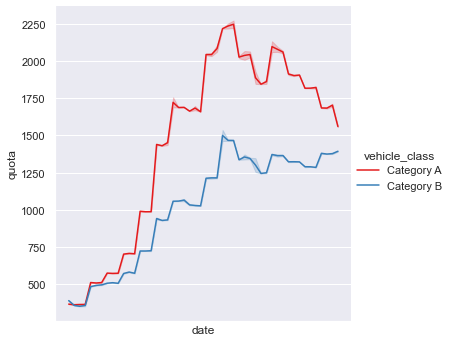

In [415]:
ax8 = sns.relplot(data=df_personal_cars, x='date', y='quota', hue='vehicle_class', kind='line')
ax8.set(xticks=[])

### Correlation 2:  Quota ~ Car Population

Why has the quota been increasing recently?

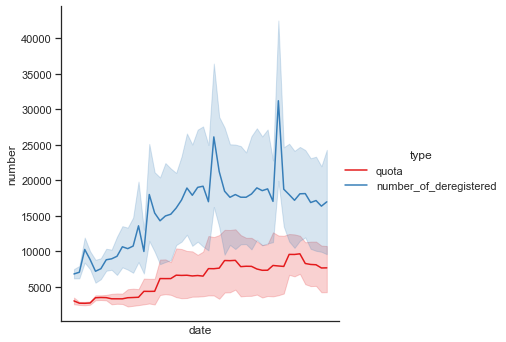

In [225]:
# number and pop
with sns.axes_style(style='ticks'):
    sns.relplot(data=df_exclude_2018[['date', 'quota', 'number_of_deregistered']].melt(id_vars='date', var_name='type', value_name='number'), x='date', y='number', kind='line', hue='type', estimator=np.sum).set(xticks=[])
    # sns.relplot(data=tmp2, x='year', y='number_of_deregistered', kind='line', estimator=np.sum, ax=ax4)

### Correlation 2:  Quota ~ Deregistered

<AxesSubplot:xlabel='date', ylabel='number'>

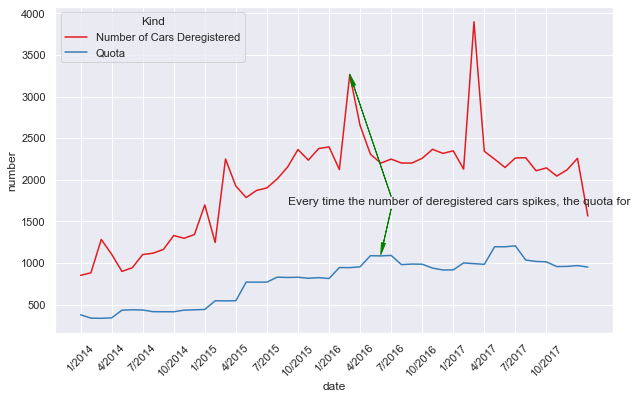

In [416]:
ax9 = sns.lineplot(data=df[['date', 'number_of_deregistered', 'quota']].melt(id_vars='date', var_name='kind', value_name='number'), x='date', y='number', hue='kind', ci=None)
ax9.set_xticks([f'{m}/{y}' for m in range(1, 12, 3) for y in range(2014, 2018)])
# ax9.set_xticklabels([f'{y} Q{q}' for q in range(1, 5) for y in range(2014, 2018)], rotation=45)
plt.xticks(rotation=45)
# print([f'{m}/{y}' for m in range(1, 12, 3) for y in range(2014, 2018)])
# print([f'{y} Q{q}' for q in range(1, 5) for y in range(2014, 2018)])
ax9.annotate('Every time the number of deregistered cars spikes, the quota for', xy=(20, 1700))
ax9.annotate('', xy=(26, 3270), xytext=(30, 1800), arrowprops=dict(width=0.1, headwidth=4, color='green'), font=dict(size=12))
ax9.annotate('', xy=(29, 1100), xytext=(30, 1650), arrowprops=dict(width=0.1, headwidth=4, color='green'), font=dict(size=12))
ax9.legend(labels=('Number of Cars Deregistered', 'Quota'), title='Kind')
ax9

### Correlation 3:  Deregistered ~ Month

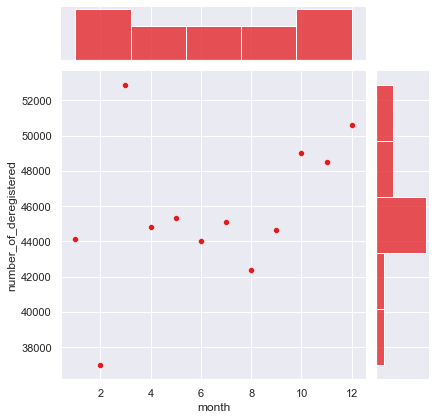

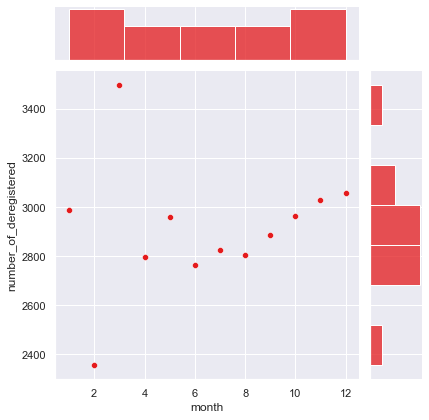

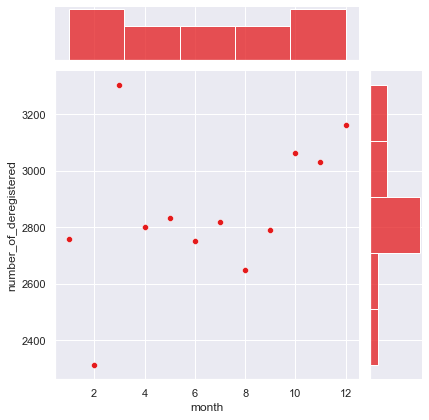

In [434]:
sns.jointplot(data=df_personal_cars[df_personal_cars['year'] != 2018].groupby('month').sum(), x='month', y='number_of_deregistered')
sns.jointplot(data=df_personal_cars[df_personal_cars['year'] != 2018].groupby('month').median(), x='month', y='number_of_deregistered')
sns.jointplot(data=df_personal_cars[df_personal_cars['year'] != 2018].groupby('month').mean(), x='month', y='number_of_deregistered')

<AxesSubplot:xlabel='month', ylabel='number_of_deregistered'>

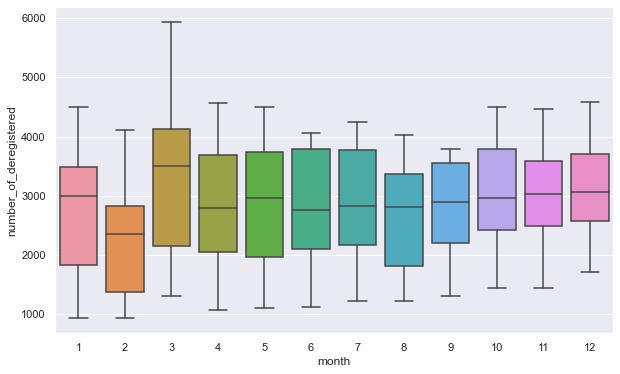

In [433]:
sns.boxplot(data=df_personal_cars[df_personal_cars['year'] != 2018], x='month', y='number_of_deregistered')

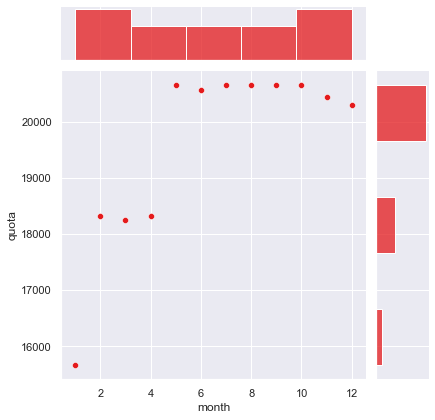

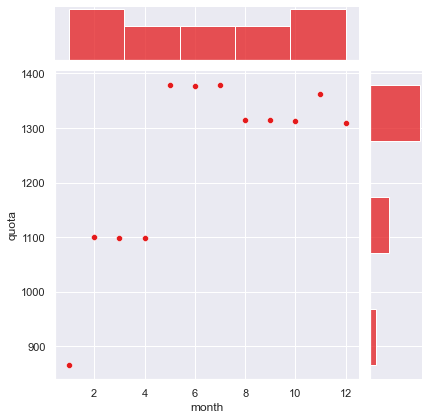

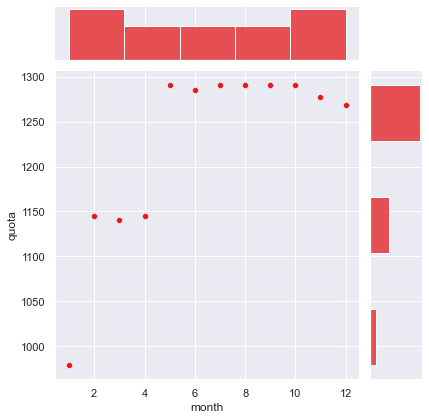

In [436]:
sns.jointplot(data=df_personal_cars[df_personal_cars['year'] != 2018].groupby('month').sum(), x='month', y='quota')
sns.jointplot(data=df_personal_cars[df_personal_cars['year'] != 2018].groupby('month').median(), x='month', y='quota')
sns.jointplot(data=df_personal_cars[df_personal_cars['year'] != 2018].groupby('month').mean(), x='month', y='quota')

Why spike dereg at start of month? Buy in april is best. dont buy in march.

### Somehow, quota not always increase but premium is

In [437]:
# Received by quota
# sns.scatterplot(data=df, x='quota', y='premium', hue='vehicle_class')
px.scatter(data_frame=df_personal_cars, x='quota', y='premium', color='vehicle_class', size='bids_success', animation_frame='date', animation_group='index', range_x=(200, 3000), range_y=(0, 100000))
# df.reset_index().assign(date=lambda x: x['month'].to_string() + '/' + x['year'].to_string()).head()

### quota, bids success and bids received all positively correlated

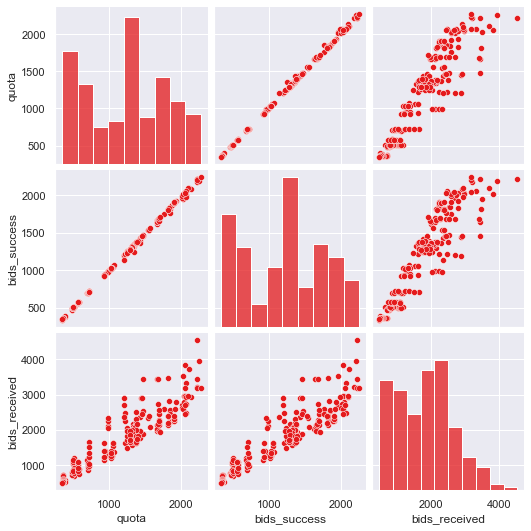

In [438]:
sns.pairplot(data=df_personal_cars[['quota', 'bids_success', 'bids_received']])

# TRASH

In [228]:
### Bids Success ~

index  bidding_no  quota  bids_success  bids_received  premium  \
year month                                                                   
2014 1        0.5         1.5  366.0         362.5          673.5  72329.5   
     2        8.5         1.5  362.0         357.0          709.5  74382.5   
     3       16.5         1.5  363.5         358.0          596.0  77800.5   
     4       24.5         1.5  364.0         358.5          525.0  74367.5   
     5       32.5         1.5  511.0         509.0          836.5  62845.5   

                pqp  number_of_deregistered  number_of_registered    number  
year month                                                                   
2014 1      76109.0                  1011.0                 844.0  341519.0  
     2      73237.0                  1104.0                 754.0  341169.0  
     3      73431.0                  1330.0                 806.0  340645.0  
     4      74838.0                  1347.0                 768.0  340066.0  
     5      75517.0                  1271.0                 905.0  339700.0

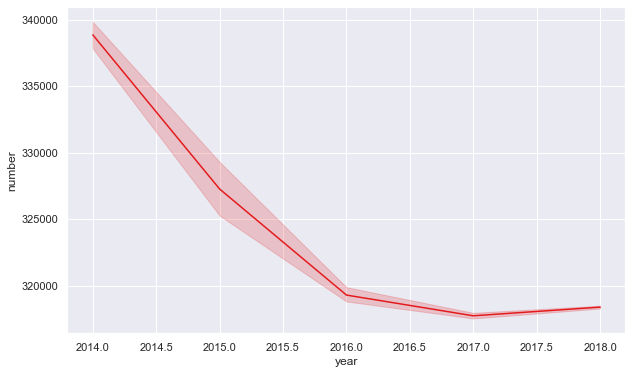

In [229]:
c = df[df['vehicle_class'].str.contains('Category A')].groupby(['year', 'month']).mean()
sns.lineplot(data=c, x='year', y='number')
c.head()

In [232]:
# Quota by year
# sns.lineplot(data=df.groupby('year').sum(), x='year', y='quota')
# df.groupby('year').sum().head()
px.scatter(data_frame=df[['date', 'quota', 'bids_received', 'bids_success']].melt(id_vars='date', var_name='kind', value_name='freq'), x='date', y='freq', color='kind')

<AxesSubplot:xlabel='vehicle_class', ylabel='year'>

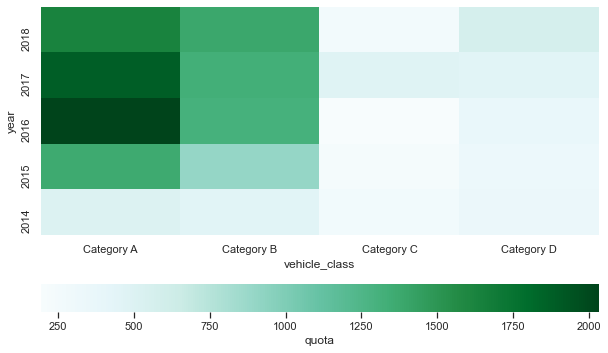

In [233]:
sns.heatmap(df.pivot_table(index='year', columns='vehicle_class', values='quota').sort_index(ascending=False), cmap='BuGn', cbar_kws={'orientation': 'horizontal', 'label': 'quota'})

In [234]:
go.Figure(go.Heatmap(z = df.pivot_table(index='year', columns='vehicle_class', values='quota').sort_index(ascending=False), colorscale='Greens', reversescale=True))

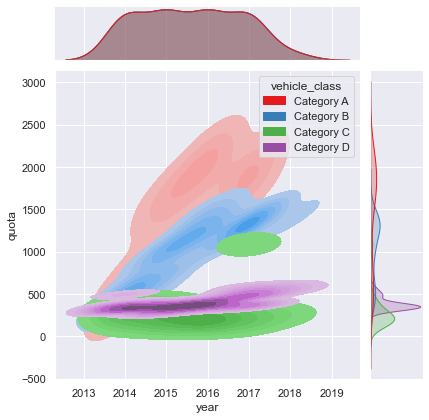

In [235]:
sns.jointplot(data=df, x='year', y='quota', hue='vehicle_class', kind='kde', fill=True)

In [236]:
px.bar(data_frame=df, x='year', y='bids_success', color='vehicle_class')

In [237]:
df.head()

,index,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium,pqp,number_of_deregistered,number_of_registered,number,year,date
0,0,1,1,Category A,364,361,623,72369,76109,1011,844,341519,2014,1/2014
1,1,1,2,Category A,368,364,724,72290,76109,1011,844,341519,2014,1/2014
2,2,1,1,Category B,386,377,581,78700,82333,927,1224,279902,2014,1/2014
3,3,1,2,Category B,393,388,512,79000,82333,927,1224,279902,2014,1/2014
4,4,1,1,Category C,258,252,337,48889,58989,711,309,154144,2014,1/2014


In [239]:
px.scatter_matrix(data_frame=df[['quota', 'bids_received', 'bids_success']])

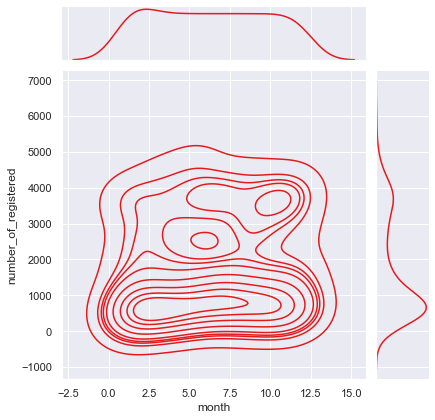

In [240]:
sns.jointplot(data=df, x='month', y='number_of_registered', kind='kde')

In [241]:
px.scatter(data_frame=df, x='month', y='premium', color='vehicle_class', size='quota', animation_frame='year', animation_group='vehicle_class')